In [1]:
import numpy as np
import proplot as pplt
import fitsio
import glob
from smatch import Matcher

## Read and Process GAIA catalog w/ matches to Gold

In [2]:
fnames = glob.glob("gaia*.fits")
d = []
for f in fnames:
    d.append(fitsio.read(f, lower=True))
d = np.concatenate(d, axis=0)

d.dtype.names

('ext_mash',
 'phot_g_mean_mag',
 'mag_auto_g',
 'mag_auto_r',
 'mag_auto_i',
 'mag_auto_z',
 'coadd_object_id',
 'source_id',
 'ra',
 'dec',
 'ra_des',
 'dec_des')

In [3]:
gmi = d["mag_auto_g"] - d["mag_auto_i"]
msk = (gmi > -4) & (gmi < 4)
d = d[msk]
gmi = gmi[msk]

In [4]:
m = Matcher(d["ra"], d["dec"])

In [5]:
angle = 2.0*np.sin(np.deg2rad(2/3600.0)/2.0)
idx = m.tree.query_ball_tree(m.tree, angle, eps=0)
nmatch = np.array([len(j) for j in idx])

In [76]:
df_dtype = d.dtype.descr

In [77]:
df_dtype += [("nmatch", "i4")]

In [78]:
df = np.zeros(len(d), dtype=df_dtype)
for n in d.dtype.names:
    df[n] = d[n]
df["nmatch"] = nmatch

In [79]:
fitsio.write("gaia_matched.fits", df, clobber=True)

## Read Piff Data and match to GAIA

In [62]:
fnames = glob.glob("piff*.fits")
dp = []
for f in fnames[150:160]:
    dp.append(fitsio.read(f, lower=True, columns=["ra", "dec", "t_data"]))
dp = np.concatenate(dp, axis=0)

dp.dtype.names

('ra', 'dec', 't_data')

In [63]:
dp.shape

(19200000,)

In [64]:
m = Matcher(dp["ra"], dp["dec"])

In [65]:
idx, ind_dp, ind_d, d12 = m.query_radius(d["ra_des"], d["dec_des"], 0.5/3600.0, return_indices=True)

In [66]:
gmi_m = gmi[ind_d]
nmatch_m = nmatch[ind_d]
ext_mash_m = d["ext_mash"][ind_d]
t = 2*dp["t_data"][ind_dp]**2

In [67]:
gmi_bins = np.linspace(0, 3, 11)

msk_s = (ext_mash_m < 2) & (nmatch_m == 1)
print(1.0 - np.mean(msk_s))

dg = []
for i in range(10):
    gmi_low = gmi_bins[i]
    gmi_high = gmi_bins[i+1]
    msk_g = (
        (
            (ext_mash_m >= 2) 
            | (
                (ext_mash_m < 2) & (nmatch_m > 1)
            )
        )
        & (gmi_m < gmi_high) & (gmi_m > gmi_low)
    )

    t_s = np.mean(t[msk_s])
    t_g = np.mean(t[msk_g])

    dg.append((t_g-t_s)/t_s)

0.01894510254867443


(0.0, 0.25)

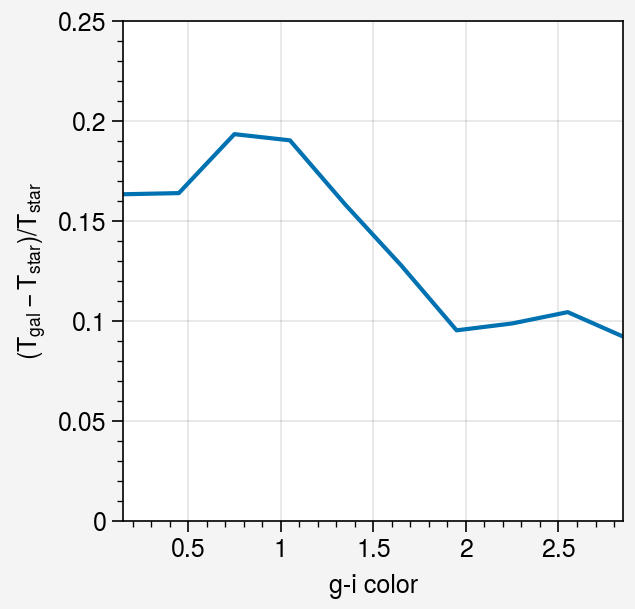

In [68]:
gmi_vals = (gmi_bins[1:] + gmi_bins[:-1])/2

fig, axs = pplt.subplots()
axs.plot(gmi_vals, dg)
axs.set_xlabel("g-i color")
axs.set_ylabel("$(T_{gal} - T_{star})/T_{star}$")
axs.set_ylim(0, 0.25)

In [11]:
def _plot_stats(gmi, nmatch, ext_mash):
    fig, axs = pplt.subplots(nrows=2, ncols=2, share=0, figsize=(8, 8))

    isgal = ((ext_mash < 2) & (nmatch == 1)).astype(int)
    h, be = np.histogram(gmi, bins=np.linspace(-4, 4, 20), weights=isgal)
    h = h.astype(float)
    m = h.copy() / d.shape[0]
    merr = np.sqrt(h) / d.shape[0]
    axs[0, 0].plot(be[:-1], m, bardata=merr)
    axs[0, 0].set_xlabel("g-i color")
    axs[0, 0].set_title("ext_mash < 2 and nmatch=1: %f" % np.mean(isgal))

    isgal = ((ext_mash >= 2) & (nmatch == 1)).astype(int)
    h, be = np.histogram(gmi, bins=np.linspace(-4, 4, 20), weights=isgal)
    h = h.astype(float)
    m = h.copy() / d.shape[0]
    merr = np.sqrt(h) / d.shape[0]
    axs[0, 1].plot(be[:-1], m, bardata=merr)
    axs[0, 1].set_xlabel("g-i color")
    axs[0, 1].set_title("ext_mash >= 2 and nmatch=1: %f" % np.mean(isgal))

    isgal = ((ext_mash < 2) & (nmatch == 2)).astype(int)
    h, be = np.histogram(gmi, bins=np.linspace(-4, 4, 20), weights=isgal)
    h = h.astype(float)
    m = h.copy() / d.shape[0]
    merr = np.sqrt(h) / d.shape[0]
    axs[1, 0].plot(be[:-1], m, bardata=merr)
    axs[1, 0].set_xlabel("g-i color")
    axs[1, 0].set_title("ext_mash < 3 and nmatch=2: %f" % np.mean(isgal))

    isgal = ((ext_mash >= 2) & (nmatch == 2)).astype(int)
    h, be = np.histogram(gmi, bins=np.linspace(-4, 4, 20), weights=isgal)
    h = h.astype(float)
    m = h.copy() / d.shape[0]
    merr = np.sqrt(h) / d.shape[0]
    axs[1, 1].plot(be[:-1], m, bardata=merr)
    axs[1, 1].set_xlabel("g-i color")
    axs[1, 1].set_title("ext_mash >= 3 and nmatch=2: %f" % np.mean(isgal))    
    
    return fig

In [12]:
def _plot_stats_hc(gmi, nmatch, ext_mash):
    fig, axs = pplt.subplots(nrows=2, ncols=2, share=0, figsize=(8, 8))

    isgal = ((ext_mash == 0) & (nmatch == 1)).astype(int)
    h, be = np.histogram(gmi, bins=np.linspace(-4, 4, 20), weights=isgal)
    h = h.astype(float)
    m = h.copy() / d.shape[0]
    merr = np.sqrt(h) / d.shape[0]
    axs[0, 0].plot(be[:-1], m, bardata=merr)
    axs[0, 0].set_xlabel("g-i color")
    axs[0, 0].set_title("ext_mash = 0 and nmatch=1: %f" % np.mean(isgal))

    isgal = ((ext_mash == 4) & (nmatch == 1)).astype(int)
    h, be = np.histogram(gmi, bins=np.linspace(-4, 4, 20), weights=isgal)
    h = h.astype(float)
    m = h.copy() / d.shape[0]
    merr = np.sqrt(h) / d.shape[0]
    axs[0, 1].plot(be[:-1], m, bardata=merr)
    axs[0, 1].set_xlabel("g-i color")
    axs[0, 1].set_title("ext_mash = 4 and nmatch=1: %f" % np.mean(isgal))

    isgal = ((ext_mash == 0) & (nmatch == 2)).astype(int)
    h, be = np.histogram(gmi, bins=np.linspace(-4, 4, 20), weights=isgal)
    h = h.astype(float)
    m = h.copy() / d.shape[0]
    merr = np.sqrt(h) / d.shape[0]
    axs[1, 0].plot(be[:-1], m, bardata=merr)
    axs[1, 0].set_xlabel("g-i color")
    axs[1, 0].set_title("ext_mash = 0 and nmatch=2: %f" % np.mean(isgal))

    isgal = ((ext_mash == 4) & (nmatch == 2)).astype(int)
    h, be = np.histogram(gmi, bins=np.linspace(-4, 4, 20), weights=isgal)
    h = h.astype(float)
    m = h.copy() / d.shape[0]
    merr = np.sqrt(h) / d.shape[0]
    axs[1, 1].plot(be[:-1], m, bardata=merr)
    axs[1, 1].set_xlabel("g-i color")
    axs[1, 1].set_title("ext_mash = 4 and nmatch=2: %f" % np.mean(isgal))    
    
    return fig

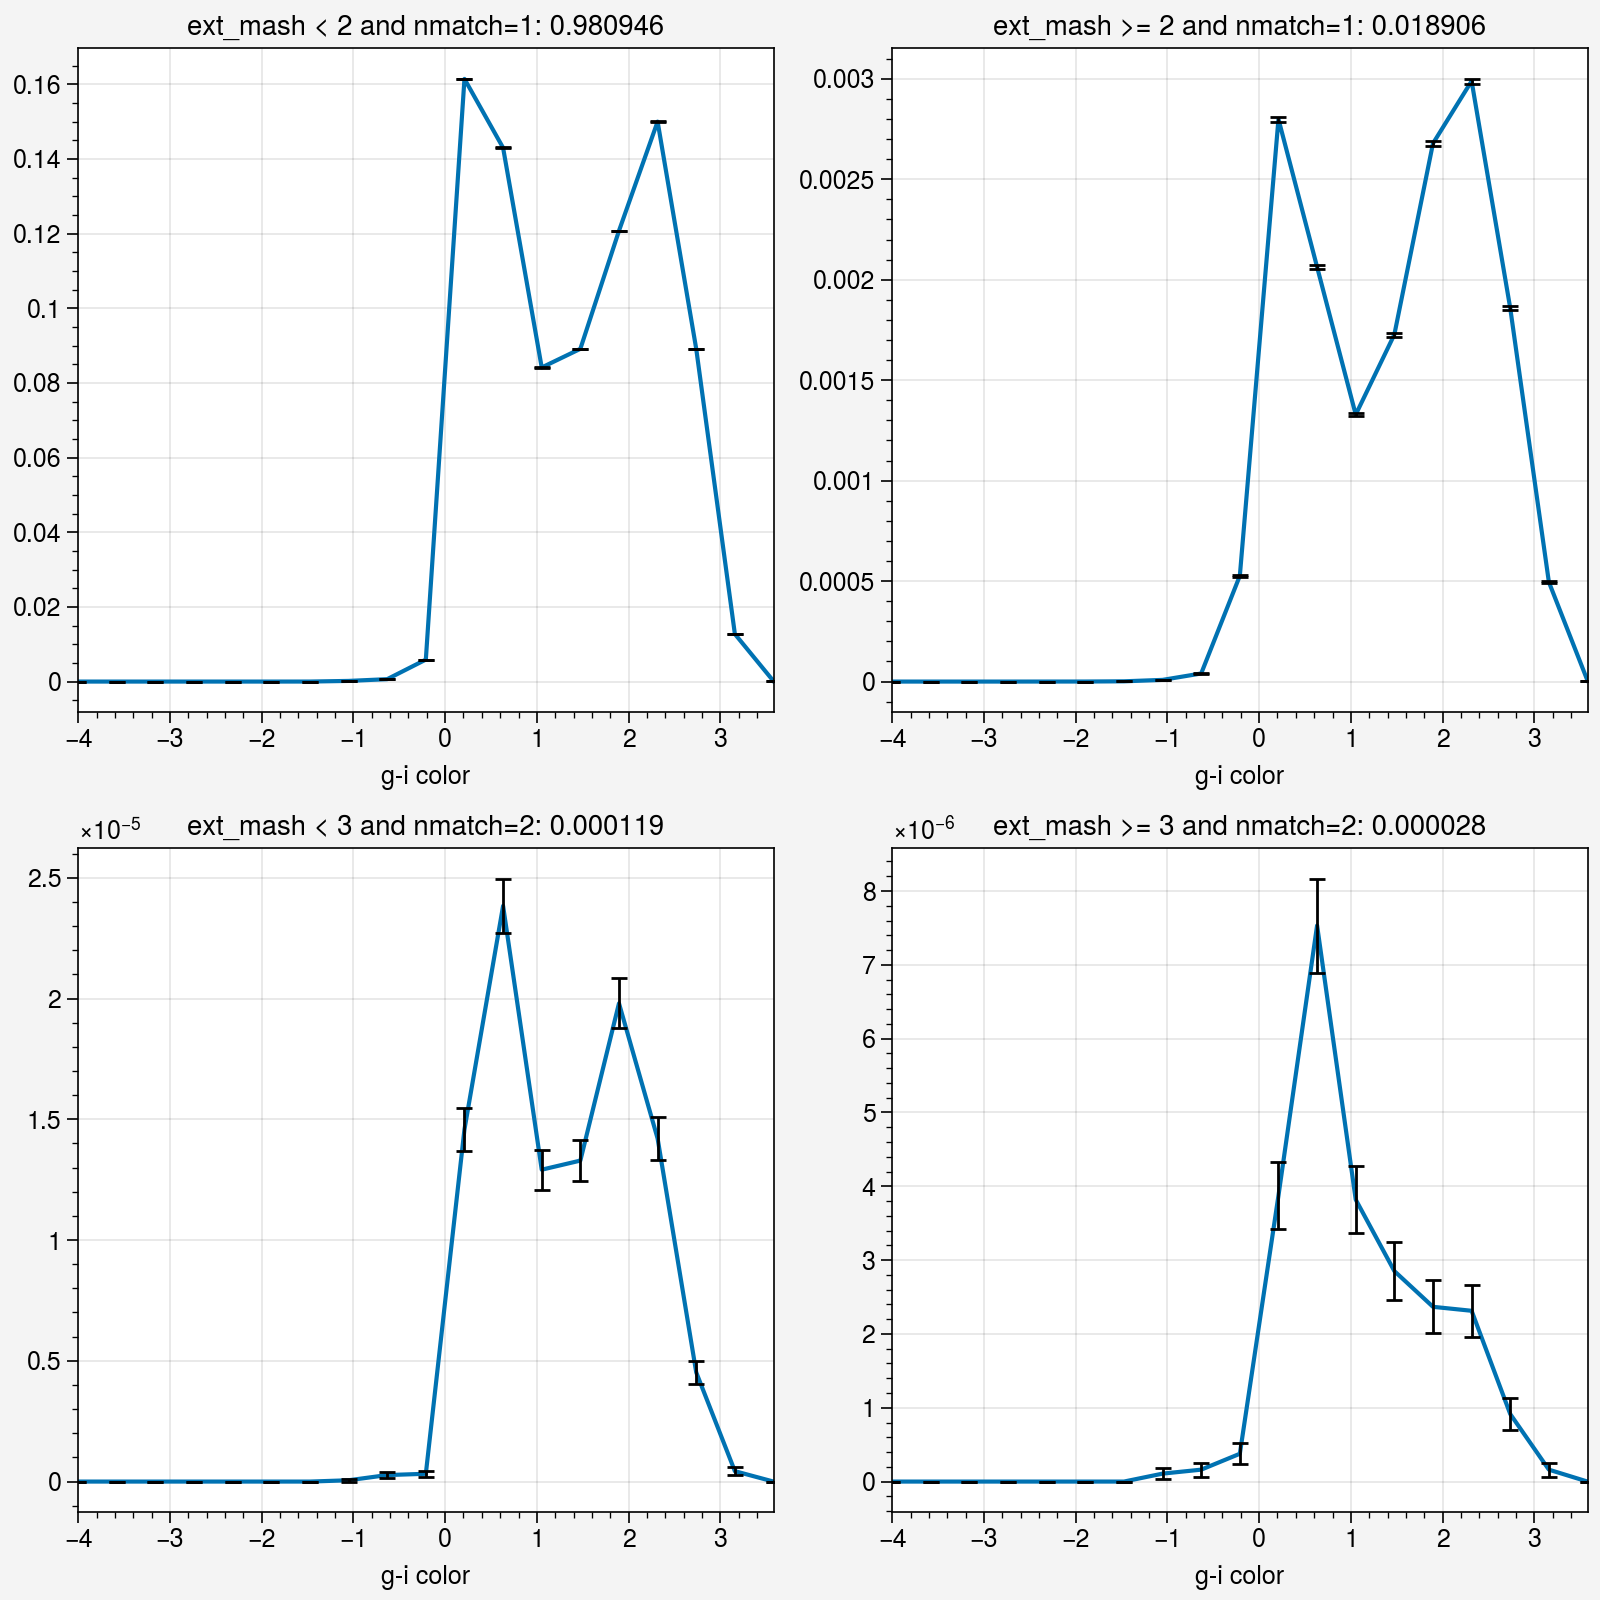

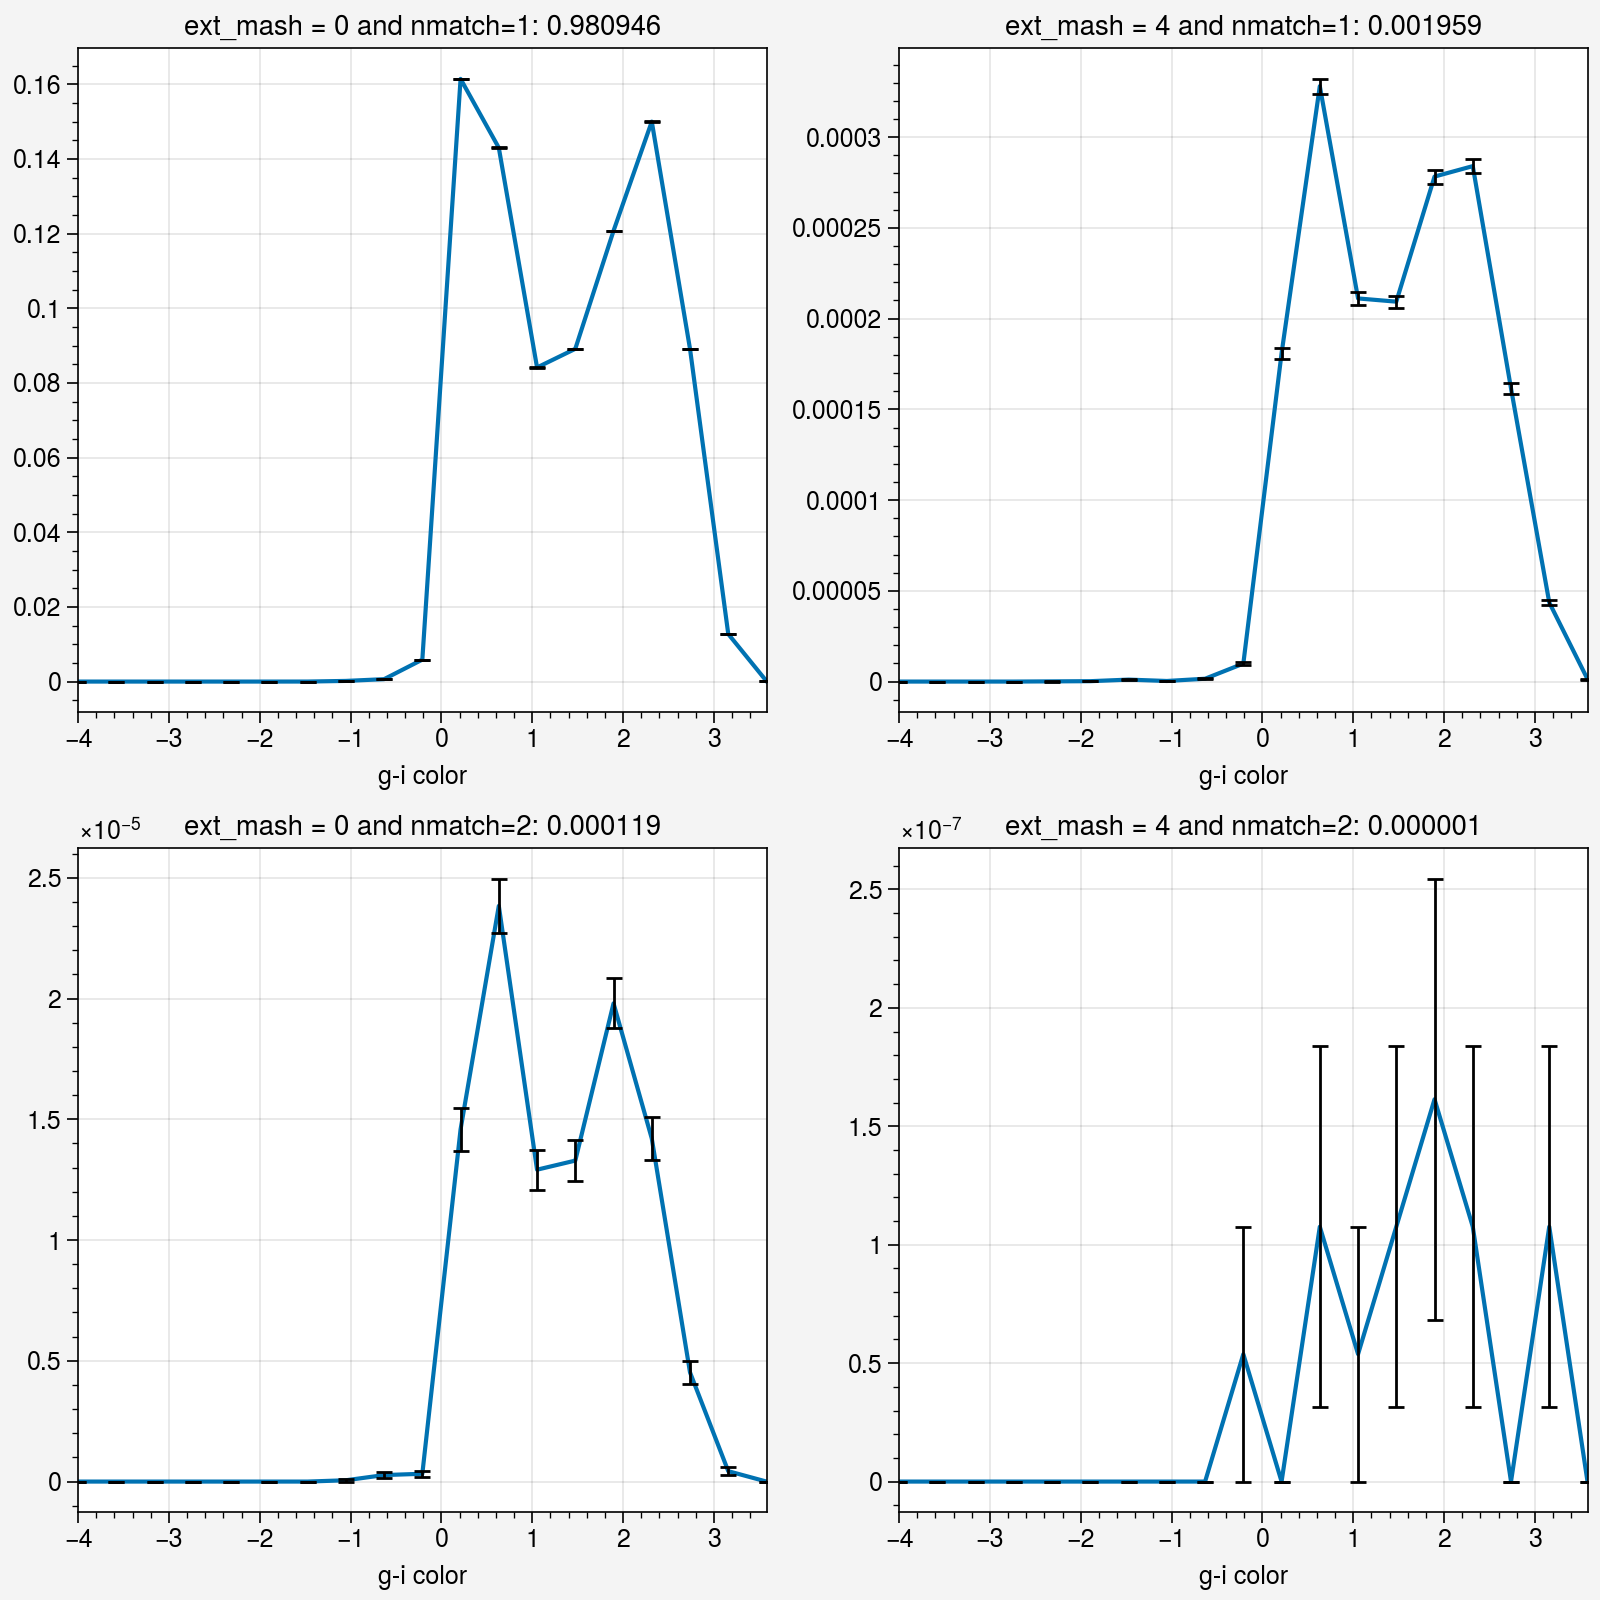

In [13]:
fig = _plot_stats(gmi_m, nmatch_m, ext_mash_m)
fig_hc = _plot_stats_hc(gmi_m, nmatch_m, ext_mash_m)

## Look at Piff Inputs 

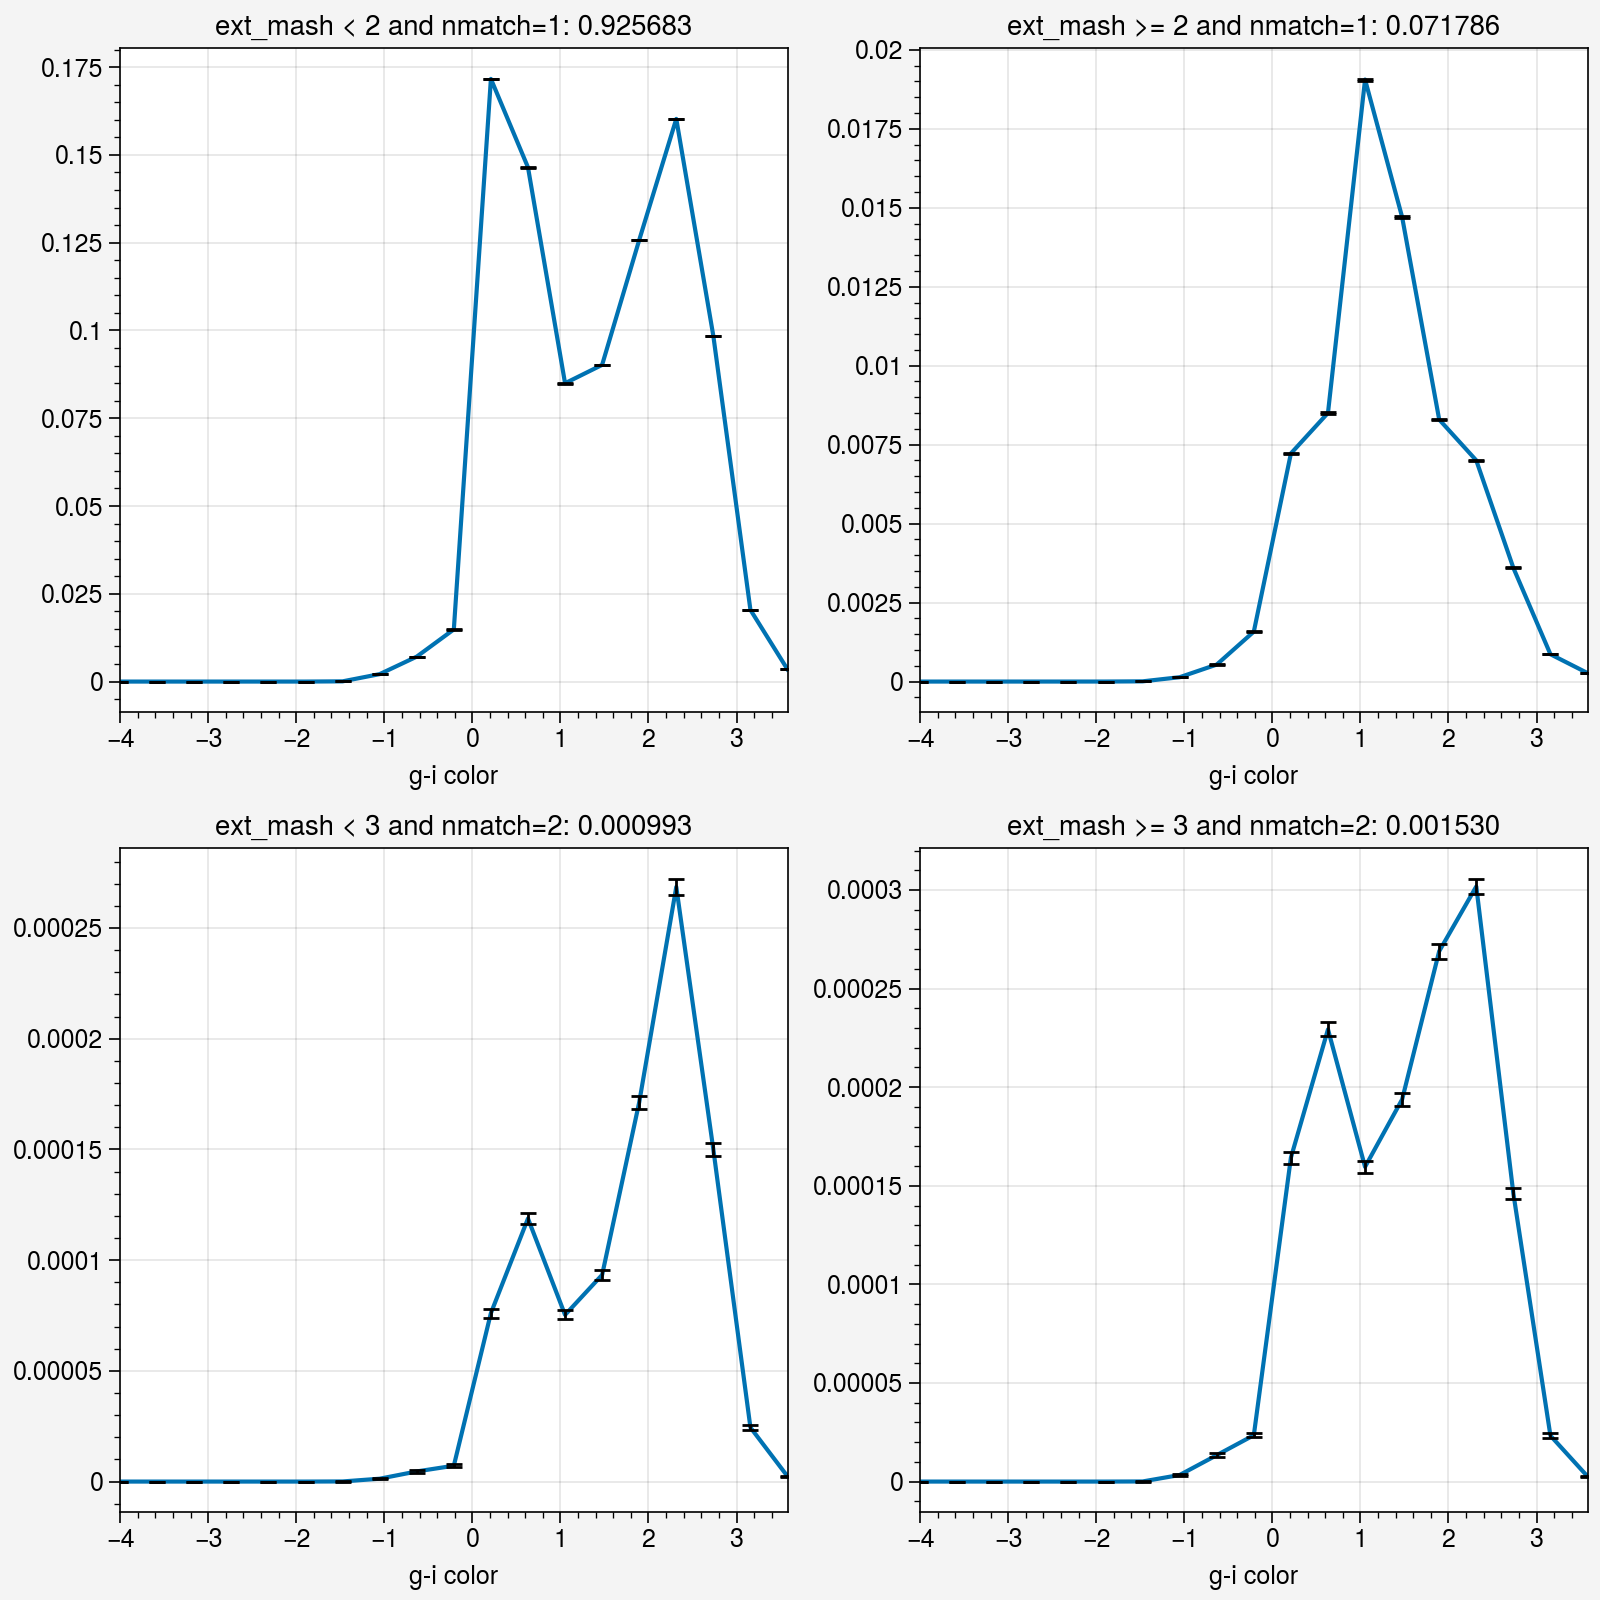

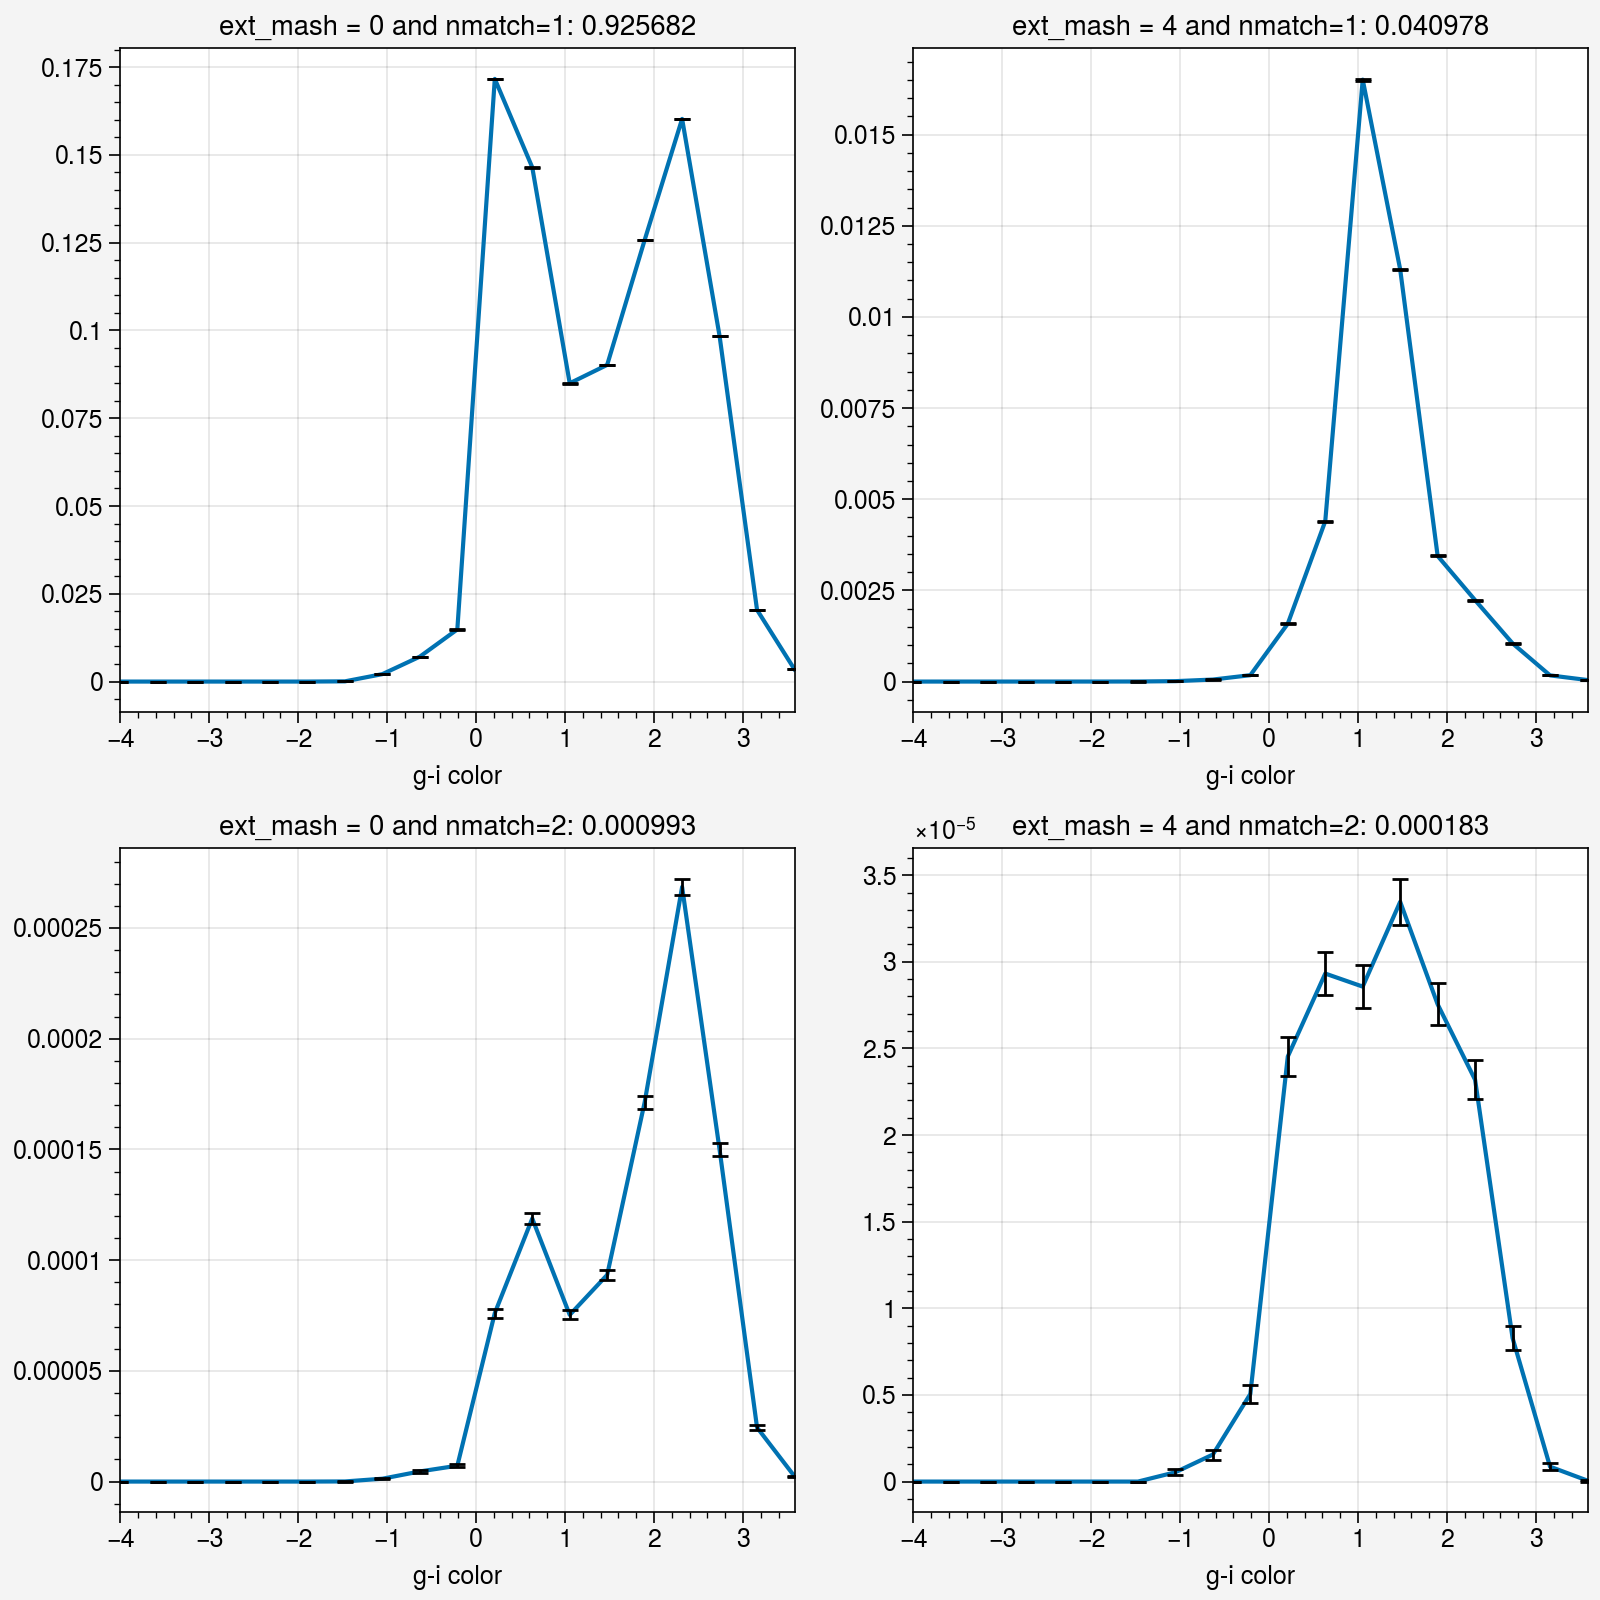

In [14]:
fig = _plot_stats(gmi, nmatch, d["ext_mash"])
fig_hc = _plot_stats_hc(gmi, nmatch, d["ext_mash"])